# Tinkering Notebook - Model-Based Reinforcement Learning

# Table of content
* ### [1. Introduction](#sec1)
* ### [2. Imports <a id="imports">](#sec2)
* ### [3. DYNA-Q <a id="dynaq">](#sec3)
 * #### [3.1 Overview](#sec3_1)
 * #### [3.2 Example: Maze](#sec3_2)
 * #### [3.3 Discussions ](#sec3_3)
* ### [4. DynaQ+<a id="dynaqplus">](#sec4)
 * #### [4.1 Overview](#sec4_1)
 * #### [4.2 Example: Blocking Maze](#sec4_2)
 * #### [4.3 Example: Shortcut Maze](#sec4_3)


# 1. Introduction <a id="sec1">

References to examples, figures and pages are to the Reinforcement Learning book by Sutton and Barto.

This notebook focuses on model based reinforcement learning and integration of learning and planning. Another important theme in the notebook is the exploitation-exploration trade-offs.  We will implement Dyna-Q (page 164) and Dyna-Q+ (page 168) and run these on the various maze environments of Example 8.1, 8.2 and 8.3.
    
Note that in this notebook we do not perform averaging over runs,  hence we typically have considerable amount of randomness in our results. This makes it difficult to draw general conclusions about the effect of parameters. You may want to perform averaging over runs after your initial experiments to be able to understand effect of parameters better. 

## Maze Environments for Dyna-Q:
    
You need to install gym-RLcourse:  

```bash
git clone https://github.com/ozayca/gym-RLcourse.git
cd gym-RLcourse
pip3 install -e .
```    
    
Run the import cell below and the next cell where you create the DynaMaze to check your installation. 
    

# 2. Imports <a id="imports"> <a id="sec2">

In [93]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import gym_RLcourse
import math

Let's create a maze: 

In [2]:
env = gym.make('DynaMaze-v0', maze_type='DM')
print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Discrete(54)
Action space: Discrete(4)


__Different Mazes:__ All mazes in Example 8.2, Example 8.3 and Example 8.4 can be created using 'DynaMaze-v0'. To create different mazes, we change the `maze_type` as follows: 

    Dyna-Maze of Figure 8.2: 'DM' 
    Maze on LHS of Figure 8.4: 'BL' (stands for Block Left)
    Maze on RHS of Figure 8.4: 'BR' (stands for Block Right)
    Maze on LHS of Figure 8.5: 'BR' (note that this maze is the same with RHS of Figure 8.4)
    Maze on RHS of Figure 8.5: 'BN' (stands for Block None)

In the above, LHS and RHS stand for left-hand side and right-hand side, respectively.  Reward is zero on all transitions, except to the one into the goal state,  on which it is 1. Goal state is always upper right most state. The starting state depends on the maze, please see Example 8.2-8.4 for detais. 

Let's make a basic check on our installation. When you run the code, you will see a $6 \times 9$ maze. The goal state  is indicated with `G`. Agent's location is indicated by `x` . The obstacles (i.e. walls) are indicated with `W`. Other states are marked with `o`.

In [3]:
env.render()

o  o  o  o  o  o  o  W  G
o  o  W  o  o  o  o  W  o
x  o  W  o  o  o  o  W  o
o  o  W  o  o  o  o  o  o
o  o  o  o  o  W  o  o  o
o  o  o  o  o  o  o  o  o



# 3. DYNA-Q <a id="dynaq"> <a id="sec3">

## 3.1 Overview <a id="sec3_1">

We now implement Tabular Dyna-Q (pg 164). 
  
The class `DynaQ` can be called to run either plain Dyna-Q (page 164)  or DynaQ+ (page 168). This is determined by  `flag_dynaq_plus`. If `flag_dynaq_plus` is 1, Dyna-Q+ runs. Otherwise, we have  plain Dyna-Q. The version with Dyna-Q+ is not implemented fully, which you will complete later in the notebook. We now focus on Dyna-Q.
      
__Task-DQ:__ Assuming `flag_dynaq_plus=0`, examine the functions  `learn()`, `update_action_value()` and `update_model()` and relate the implementation to Dyna-Q (page 164). Note that the comments on top of these functions indicate which lines of the pseudo-code on page 164 the code implements. 

In [92]:
# Tabular DynaQ, pg164 and DynaQ+, pg168,  Sutton-Barto
class DynaQ:
    def __init__(self, n_states, n_actions, env_shape, n=0, gamma=0.95,
                 epsilon=0.1, alpha=0.1, flag_dynaq_plus=0, kappa=1e-3):
        self.n_actions = n_actions
        self.actions = range(n_actions)
        self.n_states = n_states
        self.n = n  # number of planning steps
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.flag_dynaq_plus = flag_dynaq_plus
        self.kappa = kappa
        self.env_shape = env_shape
        self.q_value = np.zeros((n_states, n_actions))
        self.visited_states = [] # list of visited states
        self.visit_status_pairs = np.zeros((n_states, n_actions)) # set to 1 if state,action pair is visited
        self.model = {}
        if self.flag_dynaq_plus == 1: # see page 168
            self.time = 0  # internal counter for calls to learn()
            self.visit_last_time_pairs = np.zeros((n_states, n_actions)) # store last visit time
            for state in range(n_states):  # initialization of the model, see footnote on page 168
                [self.visited_states.append(state)  for state in range(n_states)] # initialize as all states visited
                for action in range(n_actions):
                    self.model[state, action] = state, 0  # state, reward =0

    # page 164, Tabular-Dyna-Q, step b
    def act(self, state):
        if np.random.random_sample() <= self.epsilon:  # random action wp epsilon
            action = np.random.choice(self.actions)
        else:  # greedy action wp 1-epsilon
            action = self.greedy(state)
        return action

    def greedy(self, state):
        action_values = self.q_value[state, :]
        max_value = np.max(action_values)
        indices_max_value = [i for i, j in enumerate(action_values.tolist()) if j == max_value]
        action = np.random.choice(indices_max_value)
        return action

    def best_action_value(self, state):
        return np.max(self.q_value[state, :])

    # page 164, Tabular-Dyna-Q, step d
    def update_action_value(self, state, action, state_next, reward):
        delta = reward + self.gamma * self.best_action_value(state_next) - self.q_value[state, action]
        self.q_value[state, action] += self.alpha * delta

    # page 164, Tabular-Dyna-Q, step e
    def update_model(self, state, action, state_next, reward):
        self.visited_states.append(state)
        self.visited_states = list(set(self.visited_states))  # to get a list without repetitions 
        self.visit_status_pairs[state, action] = 1
        self.model[state, action] = state_next, reward
        if self.flag_dynaq_plus == 1:
            self.visit_last_time_pairs[state, action] = self.time

    # page 164, Tabular-Dyna-Q, call functions for step d-e-f
    def learn(self, state, action, state_next, reward, done):
        self.update_action_value(state, action, state_next, reward)
        self.update_model(state, action, state_next, reward)
        self.plan()
        if self.flag_dynaq_plus == 1:
            self.time += 1
                
    # page 164, Tabular-Dyna-Q, step f
    def plan(self):
        for iPlan in range(self.n):
            state, action = self.sample_visit()
            [state_next, reward] = self.model[state, action]
            if self.flag_dynaq_plus == 1:
                time_passed = self.time - self.visit_last_time_pairs[state, action]             
                reward += self.kappa*math.sqrt(time_passed)
            self.update_action_value(state, action, state_next, reward)

    def sample_visit(self):
        state = np.random.choice(self.visited_states)
        if self.flag_dynaq_plus == 0:
            visited_actions_for_state = np.where(self.visit_status_pairs[state, :] > 0)[0]
            action = np.random.choice(visited_actions_for_state)
        else:
            action = np.random.choice(self.n_actions)
        return state, action

    #  for visualization of policy similar to Figure 8.3
    def plot_policy(self):
        directions = {0: ' U ', 1: ' R ', 2: ' D ', 3: ' L '}
        for state in range(self.n_states):
            q = self.q_value[state, :]
            if np.count_nonzero(q == q[0]) == len(q):
                action = " - "
            else:
                action = directions[self.greedy(state)]
            print(action, end='')
            position = np.unravel_index(state, self.env_shape)
            if position[1] == self.env_shape[1] - 1:
                print('')
        print('')

We now introduce `train()` function for ease of experimentation. Note that the function returns the length of episodes in `length_episodes` and rewards over all time steps `rewardA`. We will use these variables to track the behaviour of the agent. Accordingly, we have the functions `plot_length_episodes()`  and `plot_cumulative_rewards()` to create plots of these variables similar to Figure 8.2 and Figure 8.4-8.5, respectively. 

In [89]:
def train(env, agent, nEpisode, nTotalStep):
    length_episodes = np.inf*np.ones(nEpisode)
    rewardA = []
    iTotalStep = 0  # global step index over all episodes
    for iEpisode in range(nEpisode):
        done = False
        t = 0  # step index within episode
        T = np.inf
        state = env.reset()
        action = agent.act(state)
        while not done:
            if t < T:
                state_past = state
                state, reward, done, info = env.step(action)
                agent.learn(state_past, action, state, reward, done)
                rewardA.append(reward)
                action = agent.act(state)
                iTotalStep += 1
                if done:
                    agent.plot_policy() # visualize-policy
                    T = t + 1
                    length_episodes[iEpisode] = T
            t += 1
            if iTotalStep > nTotalStep:
                iEpisode = nEpisode
                done = True
    rewardA = rewardA[0:nTotalStep]
    print('Finished')
    return length_episodes, rewardA

In [90]:
def plot_length_episodes(length_episodes): # for plots similar to Figure 8.2
    plt.plot(length_episodes, label='DYNA-Q')
    plt.xlabel('Episodes')
    plt.ylabel('Steps per Episode')
    plt.legend(loc='best')
    plt.ylim(-5, 800)
    plt.grid(True)
    plt.show()

In [91]:
def plot_cumulative_rewards(rewards1, rewards2): # for plots similar to Figure 8.4
    rewards1_cumulative = np.cumsum(rewards1)
    rewards2_cumulative = np.cumsum(rewards2)
    rewards2_cumulative = np.array(rewards2_cumulative) + rewards1_cumulative[-1]
    rewards_cumulative = np.concatenate([rewards1_cumulative, rewards2_cumulative])
    plt.plot(rewards_cumulative)
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Reward')
    plt.ylim(-5, 400)
    plt.grid(True)
    plt.show()

## 3.2 Example: Maze <a id="sec3_2">

We create the DynaMaze environment of Example 8.2 and the Dyna-Q agent. 

__Task-DM:__ What is the length of the episode under an optimal deterministic strategy in the DynaMaze environment? 

In [75]:
env = gym.make('DynaMaze-v0', maze_type='DM')
agent = DynaQ(env.observation_space.n, env.action_space.n, env.shape, n = 5, gamma=0.95, epsilon=0.1, alpha=0.1)

We now run the agent on the environment. __Wait until you see 'Finished'.__ 

In [76]:
steps_episodes, rewards = train(env, agent, nEpisode = 50, nTotalStep = 100000 )

 -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  U 
 -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  U 
 -  -  -  -  -  -  -  -  U 
 -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  U 
 -  -  -  -  -  -  -  -  U 
 -  -  -  -  -  -  -  -  U 
 -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  U 
 -  -  -  -  -  -  -  -  U 
 -  -  -  -  -  -  -  R  U 
 -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  U 
 -  -  -  -  -  -  -  -  U 
 -  -  -  -  -  -  -  R  U 
 -  -  -  -  -  -  -  U  - 
 -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  - 
 -  -  -  -  -  -  -  -  U 
 -  -  -  -  -  -  -  -  U 
 -  -  -  -  -  -  R  R  U 
 -  -  -  -  -  -  -  U  - 
 -  -  -  -  - 

 D  D  -  R  R  R  D  -  U 
 R  D  -  U  -  U  R  R  U 
 -  R  R  U  -  -  U  U  - 
 -  -  -  U  L  -  -  U  - 

Finished


We plot steps per episode, similar to Figure 8.2. 

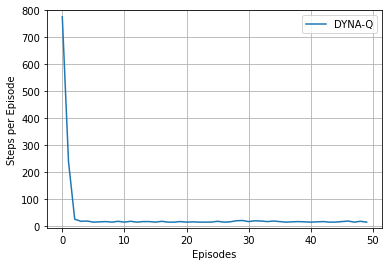

In [71]:
plot_length_episodes(steps_episodes)

We plot the agent's policy, similar to Figure 8.3. The actions are represented as follows: `U`:Up, `R`:Right, `D`:Down, `L`:Left. If  the agent has not decided on an action for a given state (i.e. all actions have the same value), we see `-`. 

In [11]:
agent.plot_policy()

 D  D  R  D  D  D  D  -  - 
 D  D  -  R  D  D  D  -  U 
 R  D  -  R  D  D  D  -  U 
 R  D  -  D  R  R  R  R  U 
 R  R  R  R  U  -  U  U  U 
 U  U  U  U  U  R  U  U  U 



## 3.3 Discussions  <a id="sec3_3">

Similar to Figure 8.2, we now provide the average performance over $50$ runs. Note that in contrast to Figure 8.2, we have included the number of steps for the first episode.  

<center><img src="figures/fig_8_82.png" width=350></center>

__Task-DQ1:__ Vary the number of planning steps `n` and plot steps per episode again using `plot_length_episodes()`. Repeat your experiments with the same parameters multiple times. Compare your results with Figure 8.2 and the above plot.

__Task-DQ2:__ Look at the evolution of the policy during training. Note that you can call `agent.plot_policy()` anytime after the agent is created. For instance, you can look at the policy at the end of each episode by uncommenting the line marked with `# visualize-policy` in the `train()` function. Vary the number of planning steps `n` and look at how policy changes. Determine if you obtain results that are consistent with your expectations and Figure 8.3.  

__Task-DQ3:__ Recall your answer to Task-DM. Even after obtaining the optimum policy, the agent take may use a higher number of steps to reach the goal. Why? 

__Task-DQ4:__ Work on Exercise 8.1 from the textbook. 

# 4. DynaQ+<a id="dynaqplus"> <a id="sec4">

## 4.1 Overview <a id="sec4_1">



We now consider DynaQ+ (page 168). Note that this is a variant of Dyna-Q and no seperate algorithm is provided on the page on page 168. You need to read the text and the footnote to understand how Dyna-Q+ is different from Dyna-Q. 

__Task-DQ+ 1:__ In `DynaQ()` class above, $\color{blue}{\text{the reward modification is not implemented for  DynaQ+}}$. In particular, we have not implemented the following statement from the book: "... if the modeled reward for a transition is $r$, and the transition has not been tried in $\tau$ time steps, then planning updates are done as if that transition produced a reward of $r + \kappa \sqrt{\tau}$, for some small $\kappa$". Complete the implementation. The location of the code you need to fill in can be found by searching for the phrase reward-modification-not-implemented in this file. 

__Task-DQ+ 2:__ Relate the idea behind Dyna-Q+ to the exploitation-exploration trade-off.

__Task-DQ+ 3:__ Relate the idea behind Dyna-Q+ to the `Optimistic Initial Values` idea in Homework 0  (see also Section 2.6.) 

## 4.2 Example: Blocking Maze <a id="sec4_2">


We now focus on Example 8.2, see page 166-167 for details. 

Run the below experiment which implements the setting in Example 8.2. The algorithm parameters are chosen using Example 8.1, our own experiments and the following reference: Sutton, R. S., *Integrated architectures for learning, planning, and reacting based on approximating dynamic programming.*, In Proceedings of the 7th International Workshop on Machine Learning, pp. 216–224, 1990. 

Note that the agents do not experience the change in the environment at exactly time step $1000$. Instead, they are allowed to finish their current episode. This prevents the possible situation where the agent finds itself in a wall. The reward gained after time step $1000$ from the first environment is ignored. Since both agents typically find the short path well before time step $1000$, the fact that they can finish the current episode and hence train a bit more does not have any effect on the results. 

In [94]:
env = gym.make('DynaMaze-v0', maze_type='BL')
agent = DynaQ(env.observation_space.n, env.action_space.n, env.shape, n=5, gamma=0.95, epsilon=0.1, alpha=1,
              flag_dynaq_plus=1, kappa=0.001)
steps_episodes1, rewards1 = train(env, agent, nEpisode=1000, nTotalStep=1000)
env = gym.make('DynaMaze-v0', maze_type='BR')
steps_episodes2, rewards2 = train(env, agent, nEpisode=1000, nTotalStep=2000)
print('Both finished')

 U  D  R  U  D  L  R  D  L 
 U  D  R  R  R  D  R  L  U 
 L  D  R  U  R  L  U  U  U 
 R  D  U  U  L  L  L  U  L 
 R  L  R  R  R  U  R  D  L 
 D  L  D  L  R  U  R  U  L 

 D  D  D  D  L  D  L  U  U 
 R  D  L  R  D  D  U  U  U 
 L  U  L  R  R  U  R  R  U 
 U  D  D  U  U  L  R  R  U 
 U  R  U  R  R  L  R  R  U 
 D  U  D  R  D  R  U  U  L 

 U  D  U  D  R  D  R  U  R 
 L  R  R  U  U  D  U  D  U 
 L  U  U  R  D  R  R  R  U 
 D  U  U  U  L  L  L  D  U 
 R  U  L  D  D  R  U  R  U 
 R  R  L  D  L  L  R  U  U 

 R  U  U  L  R  U  D  D  L 
 L  L  U  U  D  R  R  U  U 
 U  U  L  L  R  D  R  L  U 
 R  L  L  R  U  D  U  L  U 
 R  U  L  L  D  R  R  R  U 
 L  D  U  U  D  D  U  U  U 

 U  D  D  R  L  U  U  D  L 
 L  R  L  R  D  R  R  L  U 
 R  L  L  L  L  R  L  U  U 
 D  R  L  U  D  U  U  R  U 
 R  R  D  R  R  R  R  R  U 
 U  R  R  R  R  U  U  U  U 

 U  D  D  R  D  D  D  L  L 
 L  D  L  R  D  U  R  D  U 
 R  L  R  R  L  R  R  U  U 
 R  R  L  R  D  L  D  L  U 
 R  R  R  R  D  R  R  R  U 
 L  R  R  R  R 

 D  U  U  R  L  R  U  L  U 

 R  R  U  R  D  R  R  R  R 
 D  D  R  R  R  U  U  D  U 
 R  D  D  R  U  U  R  R  U 
 R  R  U  L  R  R  R  U  U 
 U  L  L  U  L  R  L  R  R 
 D  D  U  D  U  R  U  L  U 

 R  L  U  L  D  R  R  R  R 
 D  R  R  R  R  U  U  D  U 
 L  D  U  R  R  U  R  R  U 
 L  U  D  L  L  U  L  U  U 
 U  R  R  U  L  R  L  R  U 
 D  L  U  U  R  R  U  L  U 

 R  R  U  R  D  R  R  R  R 
 R  R  R  R  R  R  R  U  U 
 R  U  R  U  U  U  U  R  U 
 D  R  L  U  R  D  D  D  U 
 L  U  U  L  U  R  D  R  D 
 D  D  L  L  U  D  L  R  U 

 R  R  R  R  D  R  R  R  U 
 R  R  R  R  R  R  R  U  U 
 R  R  R  U  U  U  U  R  U 
 U  D  L  D  U  D  U  U  U 
 U  R  U  L  R  R  D  R  U 
 R  L  U  U  U  U  L  R  U 

 R  R  R  R  R  R  R  R  D 
 R  R  R  U  U  R  R  U  U 
 U  U  U  U  U  U  U  R  U 
 U  R  L  R  U  R  D  R  U 
 U  L  L  L  U  L  L  L  R 
 U  L  U  U  U  L  D  L  L 

 R  R  R  R  R  R  R  R  L 
 U  U  U  R  U  R  R  U  U 
 R  U  U  R  U  U  U  R  U 
 U  U  L  D  R  R  D  L  U 
 U  L  L  L  U

 R  R  R  R  R  R  R  R  D 
 R  U  R  U  U  R  R  U  U 
 R  U  R  R  R  R  U  R  U 
 U  U  R  R  U  D  R  U  U 
 U  L  L  L  L  L  L  L  L 
 U  L  U  L  U  U  L  L  L 

 R  R  R  R  R  R  R  R  L 
 R  R  R  U  R  R  R  U  U 
 R  R  R  R  R  R  U  R  U 
 U  R  U  D  U  L  R  U  U 
 U  L  L  L  L  L  L  L  L 
 U  L  L  L  U  U  L  L  L 

 R  R  R  R  R  R  R  R  L 
 R  R  U  U  R  R  U  U  U 
 U  R  R  U  R  R  U  R  U 
 U  U  R  R  U  D  U  R  U 
 U  L  L  L  L  L  L  L  L 
 U  L  U  U  U  U  L  L  L 

 R  R  R  R  R  R  R  R  R 
 R  R  R  U  U  R  R  U  U 
 R  R  U  R  R  R  U  R  U 
 U  U  U  D  D  L  U  R  U 
 U  L  L  L  L  L  L  L  L 
 U  L  U  U  L  U  L  L  L 

 R  R  R  R  R  R  R  R  U 
 R  R  R  R  U  R  R  U  U 
 R  R  R  R  R  R  U  R  U 
 U  L  U  L  D  R  U  U  U 
 U  L  L  L  L  L  L  L  L 
 U  L  U  L  L  U  L  L  L 

 R  R  R  R  R  R  R  R  U 
 R  R  U  U  R  R  R  U  U 
 R  U  R  R  R  U  U  R  U 
 U  L  R  D  U  L  U  R  U 
 U  L  L  L  L  L  L  L  L 
 U  L  L  U  U 

 __Wait until you see "Both finished."__ We now plot the cumulative reward versus time steps, similar to Figure 8.4. 

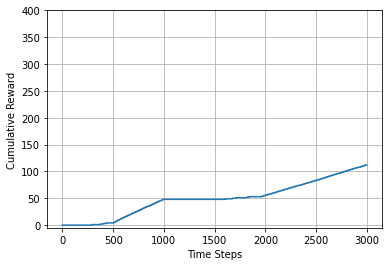

In [95]:
plot_cumulative_rewards(rewards1, rewards2)

### Discussions



Similar to Figure 8.4, we now provide the average performance over $50$ runs.  The parameters in the above experiment are used, except here we have $n=15$. 

<center><img src="figures/fig_8_84.png" width=350></center>

__Task-BM1:__ Run the experiment a few times with both DynaQ and DynaQ+ with different $n$ values. Compare your observations with Figure 8.4, the above plot and your expectations. 

__Task-BM2:__ Experiment with different $\kappa$ parameters. Try to use extremely large/small values. How does $\kappa$ change the results? Why? 

__Task-BM3:__ Visualize the agent's behaviour after the environment change using `env.render()`. Does the agent wander around the now blocked right-hand side path as you expect? How does $n$ and $\kappa$ change this behaviour?

## 4.3 Example: Shortcut Maze <a id="sec4_3">



We now focus on Example 8.3, where a shortcut opens at time step $3000$. The question is whether the agent can recognize there is a shortcut. See page 167 for details.

Run the below experiment which implements the setting in Example in 8.3. 

In [83]:
env = gym.make('DynaMaze-v0', maze_type='BR')
agent = DynaQ(env.observation_space.n, env.action_space.n, env.shape, n=5, gamma=0.95, epsilon=0.1, alpha=1,
              flag_dynaq_plus=1, kappa=0.001)
steps_episodes1, rewards1 = train(env, agent, nEpisode=1000, nTotalStep=3000)
env = gym.make('DynaMaze-v0', maze_type='BN')
steps_episodes2, rewards2 = train(env, agent, nEpisode=1000, nTotalStep=3000)
print('Both finished')

 R  D  U  D  U  L  U  U  L 
 R  D  R  R  R  R  R  L  U 
 R  D  L  U  U  D  L  R  D 
 U  U  L  L  U  L  D  L  U 
 U  D  D  L  R  D  D  R  L 
 U  D  R  R  R  L  D  D  D 

 L  R  R  R  R  D  D  D  D 
 L  R  U  U  R  R  R  R  U 
 L  L  R  R  U  R  U  U  L 
 L  L  U  R  R  L  R  U  L 
 R  D  R  D  L  L  L  D  L 
 U  D  D  L  U  U  U  R  U 

 D  R  R  R  R  D  R  D  L 
 R  R  R  R  R  R  R  R  U 
 R  R  R  R  U  U  D  U  L 
 U  L  L  R  R  L  L  L  D 
 L  R  R  D  L  L  L  D  L 
 R  R  L  U  U  U  U  R  U 

 D  R  R  R  R  D  R  D  U 
 R  R  R  R  R  R  R  R  U 
 U  U  R  U  U  U  R  U  L 
 U  R  L  R  U  D  L  D  D 
 U  L  L  L  U  D  D  R  D 
 U  L  U  L  R  L  L  L  R 

 D  D  R  R  D  D  R  D  U 
 R  R  R  R  R  R  R  R  U 
 R  R  R  U  U  U  U  U  L 
 U  U  L  D  L  U  L  L  U 
 U  L  L  L  D  L  D  R  R 
 U  L  L  L  L  L  L  L  R 

 D  D  R  R  D  D  L  D  U 
 R  R  R  R  R  R  R  R  U 
 R  R  R  U  U  U  D  U  L 
 U  L  U  D  L  D  U  L  U 
 U  L  L  L  L  L  L  D  R 
 U  L  L  L  L 

 R  D  R  R  R  D  D  D  L 
 R  R  R  R  R  R  R  R  U 
 R  R  R  U  U  U  L  U  L 
 U  R  D  D  D  R  R  D  L 
 U  L  L  L  L  U  L  D  D 
 U  U  L  L  D  L  U  L  L 

 R  D  R  R  R  D  D  D  L 
 R  R  R  R  R  R  R  R  U 
 R  R  R  R  U  U  L  U  L 
 U  D  D  L  R  D  U  R  L 
 U  L  L  L  L  R  L  L  L 
 U  U  U  U  D  L  U  L  L 

 R  R  R  R  D  D  D  D  L 
 R  R  R  R  R  R  R  R  U 
 R  R  R  R  U  U  L  U  L 
 U  R  U  R  U  R  L  D  L 
 U  L  L  L  L  R  L  L  L 
 U  U  U  L  D  L  U  L  R 

 D  R  R  D  D  D  U  D  R 
 R  R  R  R  R  R  R  R  U 
 U  R  U  R  R  U  L  U  L 
 U  R  L  D  D  L  R  R  R 
 U  L  L  L  L  U  L  L  D 
 U  L  L  L  D  L  U  L  R 

 D  R  R  D  D  D  L  D  L 
 R  R  R  R  R  R  R  R  U 
 U  U  U  R  R  U  L  U  L 
 U  R  L  R  L  R  R  R  D 
 U  L  L  L  L  U  U  L  D 
 U  L  L  L  L  L  U  L  R 

 D  R  R  D  D  D  U  D  L 
 R  R  R  R  R  R  R  R  U 
 U  U  U  R  R  U  L  U  L 
 U  U  L  L  L  D  D  D  L 
 U  L  L  L  L  U  U  L  D 
 U  U  L  L  L 

 R  R  R  R  R  R  R  D  R 
 R  R  R  R  R  R  R  R  U 
 R  R  R  R  R  U  L  U  L 
 U  R  R  U  U  R  U  U  R 
 U  L  L  L  L  L  D  R  U 
 U  U  L  L  R  L  R  U  R 

 R  R  R  R  R  R  R  D  D 
 R  R  R  R  R  R  R  R  U 
 U  R  R  R  U  U  L  U  L 
 U  U  D  U  D  D  D  U  R 
 U  L  L  L  L  R  D  R  R 
 U  L  L  L  R  R  R  R  R 

 R  R  R  R  R  R  R  D  L 
 R  R  R  R  R  R  R  R  U 
 U  R  R  R  U  U  L  U  L 
 U  L  D  L  U  D  D  L  L 
 U  L  L  L  L  U  D  R  U 
 U  L  L  L  R  R  R  R  R 

 R  R  R  R  R  R  R  D  R 
 R  R  R  R  R  R  R  R  U 
 U  U  R  R  U  U  L  U  L 
 U  D  L  L  D  R  L  U  D 
 U  L  L  L  L  R  D  R  U 
 U  L  U  U  U  L  R  U  R 

 R  R  R  R  R  R  R  D  R 
 R  R  R  R  R  R  R  R  U 
 R  U  R  R  U  U  L  U  L 
 U  R  L  L  U  U  R  U  U 
 U  L  L  U  L  U  D  R  U 
 U  L  U  L  U  L  R  U  R 

 R  R  R  R  R  R  R  D  R 
 R  R  R  R  R  R  R  R  U 
 U  U  R  R  R  U  L  U  L 
 U  R  L  L  D  U  R  D  U 
 U  L  L  L  L  L  D  R  U 
 U  U  L  L  U 

 R  D  R  R  R  R  D  D  D 
 R  R  R  R  R  R  R  R  U 
 R  R  R  R  R  U  L  U  U 
 U  R  D  R  R  D  U  U  U 
 U  R  R  R  R  R  R  R  U 
 R  R  R  U  U  R  R  R  U 

 R  D  R  R  R  R  D  D  L 
 R  R  R  R  R  R  R  R  U 
 R  R  R  R  R  U  L  U  U 
 U  R  D  R  R  R  L  U  U 
 U  R  R  R  R  R  R  R  U 
 R  R  R  U  U  R  R  R  U 

 R  D  R  R  R  R  R  D  D 
 R  R  R  R  R  R  R  R  U 
 R  R  R  R  R  U  L  U  U 
 U  R  D  R  L  D  L  U  U 
 U  R  R  R  R  R  R  R  U 
 R  R  R  U  U  R  R  R  U 

 R  D  R  R  R  R  R  D  R 
 R  R  R  R  R  R  R  R  U 
 R  R  R  R  R  U  L  U  U 
 U  R  D  U  L  D  R  U  U 
 U  R  R  R  R  R  R  R  U 
 R  R  R  R  U  R  U  R  U 

 R  D  R  R  R  R  R  D  U 
 R  R  R  R  R  R  R  R  U 
 R  R  R  R  R  U  L  U  U 
 U  R  D  U  R  L  L  U  U 
 U  R  R  R  R  R  R  R  U 
 R  R  R  U  R  R  R  R  U 

 R  D  R  R  R  R  R  D  U 
 R  R  R  R  R  R  R  R  U 
 R  R  R  R  R  U  L  U  U 
 U  R  D  U  R  L  R  R  U 
 U  R  R  R  R  R  R  R  U 
 R  R  R  U  R 

 R  R  R  R  R  R  R  R  U 
 R  R  U  U  R  U  L  U  U 
 U  R  R  L  R  D  D  L  U 
 U  R  R  R  R  R  R  R  U 
 U  L  R  R  R  R  R  R  U 

 R  R  D  R  R  R  D  D  U 
 R  R  R  R  R  R  R  R  U 
 R  R  U  U  U  U  L  U  U 
 U  R  R  R  L  R  D  U  U 
 U  L  R  R  R  R  R  R  U 
 U  L  R  R  R  R  R  R  U 

 R  R  R  R  R  R  D  D  R 
 R  R  R  R  R  R  R  R  U 
 R  R  U  U  U  U  L  U  U 
 U  R  D  L  L  D  D  L  U 
 U  L  R  R  R  R  R  R  U 
 U  U  R  U  R  R  U  R  U 

 D  R  R  R  R  R  D  D  R 
 R  R  R  R  R  R  R  R  U 
 U  R  U  U  U  U  L  U  U 
 U  R  D  L  D  L  R  L  U 
 U  L  R  R  R  R  R  R  U 
 U  L  R  R  U  R  U  R  U 

 R  R  R  R  R  R  D  D  U 
 R  R  R  R  R  R  R  R  U 
 U  R  U  U  U  U  L  U  U 
 U  R  D  L  D  R  U  L  U 
 U  L  R  R  R  R  R  R  U 
 U  L  U  R  R  R  U  R  U 

 R  R  R  R  R  R  D  D  L 
 R  R  R  R  R  R  R  R  U 
 U  R  U  U  R  U  L  U  U 
 U  R  D  D  D  R  L  L  U 
 U  L  R  R  R  R  R  R  U 
 U  L  U  U  R  R  U  U  U 

 R  R  R  R  R

 U  R  U  R  L  D  L  L  U 
 U  L  R  R  R  R  R  R  U 
 U  L  R  R  U  R  U  R  U 

 R  R  R  R  R  R  R  D  L 
 R  R  R  R  R  R  R  R  U 
 R  R  U  R  U  U  L  U  U 
 U  U  U  R  U  L  R  L  U 
 U  L  R  R  R  R  R  R  U 
 U  L  R  R  R  R  U  R  U 

 R  R  R  R  R  R  R  D  U 
 R  R  R  R  R  R  R  R  U 
 R  R  U  R  U  U  L  U  U 
 U  U  R  R  U  U  D  L  U 
 U  L  R  R  R  R  R  R  U 
 U  L  R  R  R  R  U  R  U 

 R  R  R  R  R  R  R  D  D 
 R  R  R  R  R  R  R  R  U 
 U  R  R  R  U  U  L  U  U 
 U  R  R  L  L  L  R  D  U 
 U  R  R  R  R  R  R  R  U 
 U  L  R  R  R  U  R  R  U 

 R  R  R  R  R  R  R  D  D 
 R  R  R  R  R  R  R  R  U 
 U  R  R  U  U  U  L  U  U 
 U  R  R  L  L  L  R  R  U 
 U  R  R  R  R  R  R  R  U 
 U  L  R  U  R  U  R  R  U 

 R  R  R  R  R  R  R  D  R 
 R  R  R  R  R  R  R  R  U 
 U  R  R  U  U  U  L  U  U 
 U  D  R  L  D  L  R  R  U 
 U  R  R  R  R  R  R  R  U 
 U  L  R  R  R  U  R  R  U 

 R  R  R  R  R  R  R  D  U 
 R  R  R  R  R  R  R  R  U 
 U  R  R  U  U

 R  D  R  R  R  R  R  D  L 
 R  R  R  R  R  R  R  R  U 
 U  U  U  U  U  U  L  U  U 
 U  D  R  L  R  D  R  R  U 
 U  L  L  R  R  R  R  R  U 
 U  L  L  R  R  R  R  U  U 

 R  D  R  R  R  R  R  D  L 
 R  R  R  R  R  R  R  R  U 
 U  R  U  R  U  U  L  U  U 
 U  D  U  L  U  L  R  L  U 
 U  L  L  R  R  R  R  R  U 
 L  U  U  U  R  U  R  R  U 

 R  D  R  R  R  R  R  D  L 
 R  R  R  R  R  R  R  R  U 
 U  R  U  R  U  U  L  U  U 
 U  D  D  R  R  U  U  D  U 
 U  L  L  R  R  R  R  R  U 
 U  U  U  U  R  U  R  R  U 

 R  D  R  R  R  R  R  D  U 
 R  R  U  U  R  R  R  R  U 
 U  R  U  R  R  U  L  U  U 
 U  R  D  L  D  L  U  D  U 
 U  L  L  R  R  R  R  R  U 
 U  U  U  R  R  U  R  R  U 

 R  D  R  R  R  R  R  D  U 
 R  R  U  U  R  R  R  R  U 
 U  R  R  R  R  U  L  U  U 
 U  U  R  L  D  D  L  L  U 
 U  L  L  R  R  R  R  R  U 
 U  U  U  R  R  U  R  U  U 

 R  D  R  R  R  R  R  D  L 
 R  R  U  U  R  R  R  R  U 
 U  R  R  R  R  U  L  U  U 
 U  D  R  L  D  R  L  R  U 
 U  L  L  R  R  R  R  R  U 
 U  U  U  R  U 

__Wait until you see "Both finished."__ We now plot the cumulative reward versus time steps, similar to Figure 8.4. 

In [ ]:
plot_cumulative_rewards(rewards1, rewards2)

### Discussions



Similar to Figure 8.5, we now provide the average performance over $50$ runs. The parameters in the above experiment  are used, except here we have $n=50$. 

<center><img src="figures/fig_8_85.png" width=350></center>

__Task-DQ+SM1:__ Run the experiment a few times with both DynaQ and DynaQ+ with different $n$ values. Look carefully the average cumulative reward for the last $1000$ steps of the first phase (i.e. before time step $3000$) and the second phase, i.e. the slope of the curves after convergence. Compare your observations with Figure 8.4, the above plot and your expectations. 

__Task-DQ+SM2:__ Experiment with different $\kappa$ parameters. Which $\kappa$ parameters are 'better' for the second phase (i.e. after the environment change)? Explain your observations. 

__Task-DQ+SM3:__ DynaQ+ changes the estimated values of state-action pairs instead of only modifying the action selection procedure with an extra reward. It is interesting to look at whether this is necessary. Accordingly, work on Exercise 8.4.   

__Task-DQ+SM4:__ A simple idea to encourage exploration and hence make the agent to find the shortcut in Example 8.3 is to change $\epsilon$ in $\epsilon$-greedy policy. 

- Can we make the agent solve the short-cut maze after the change at $3000$ by using a higher $\epsilon$ value? How will this modification affect the performance in the first phase? 

- Suggest a method to change $\epsilon$ in a more intelligent way, such as  'time-step aware' and/or 'situation aware' manner.  (The agent still has to infer the situation by looking at the data that is available to it; it cannot assume a change at $3000$ a priori.)
Implement your ideas. Compare your observations with your expectations. 

__Task-DQ+SM5:__ DynaQ+ uses an additional reward of $\kappa \sqrt{\tau(s,a)}$ where $(s,a)$ is the state-action pair. This form of the additional reward is a heuristic choice. Suggest similar heuristic ideas and state why they can be useful. For instance, how about $\kappa \tau(s,a)$, i.e. without the square-root? Or one can get inspired by upper-confidence bound selection for multi-armed bandits and use  $\kappa \sqrt{\frac{\ln(t)}{N_t(a,s)}}$ where $N_t(a,s)$ is the number of visits to the state-action pair at until time $t$, similar to Eqn. 2.10. Note that the form of this additional term is indeed a heuristic choice and there is no one 'correct' form (but there may be obviously wrong ones). The point of this exercise is to brainstorm about different ideas and see which type of ideas are meaningful from the perspective of exploration-exploitation trade-off.